In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
#from torchsummary import summary
from torch.optim import lr_scheduler


# Dataset
from CoinDataset import CoinDataset


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tnrange
import time
import copy

%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

In [3]:

# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [4]:

# from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, resnet101, ResNet101_Weights 
from torchvision.models import vit_b_16, ViT_B_16_Weights


# New weights with accuracy 80.858%
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)
resnet101(weights=ResNet101_Weights.DEFAULT)
vit_b_16(weights='IMAGENET1K_SWAG_E2E_V1')


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Adding Class Labels

Number of Classes with samples 83


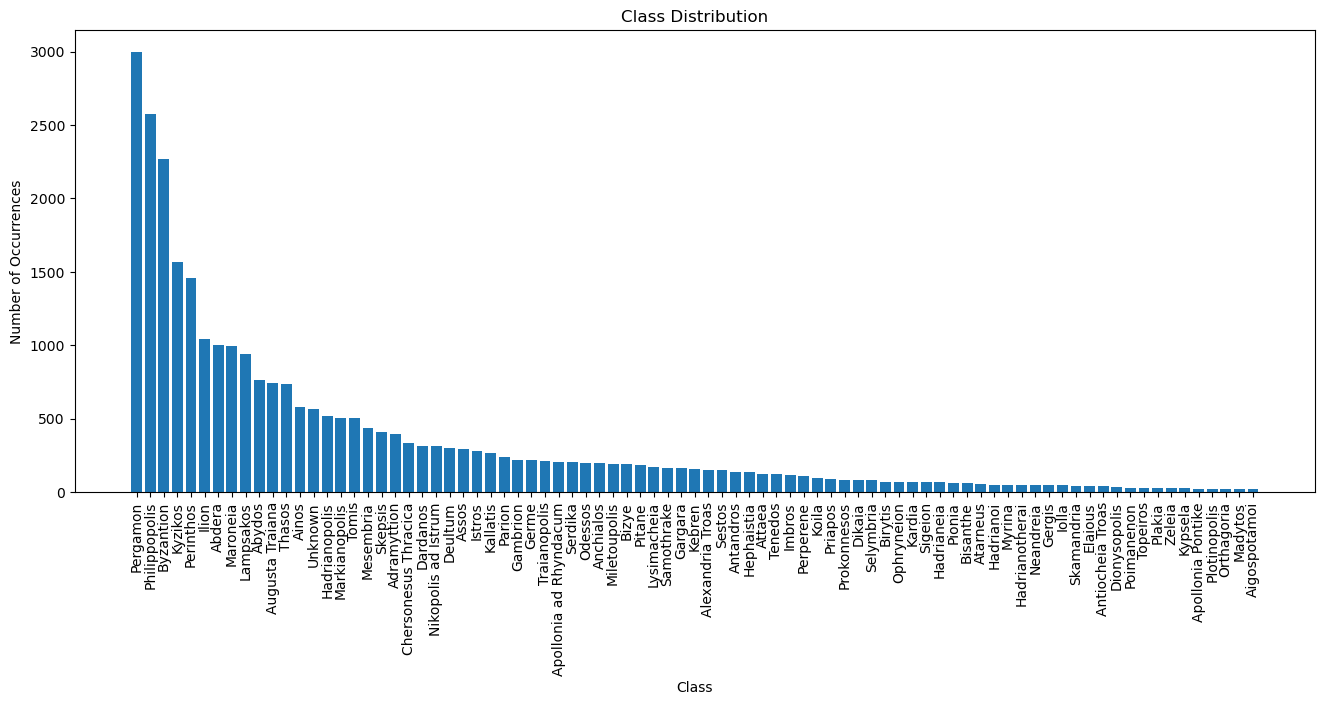

Number of classes with less than 20 occurrences: 0


In [5]:

df = pd.read_csv(r"F:\Users\basti\Documents\Goethe Uni\Data Challange\dataset.csv", delimiter=',', skiprows=0, low_memory=False, encoding='iso-8859-1')

unique_classes = df["class"].unique()
print("Number of Classes with samples", len(unique_classes))

class_map = { geo: i for i, geo in enumerate(unique_classes)}

df["class_index"] = df.apply(lambda x: class_map[x["class"]], axis=1)

df[["filename", "image_name","class", "class_index"]].to_csv(r"F:\Users\basti\Documents\Goethe Uni\Data Challange\dataset2.csv", index=False)

class_counts = df["class"].value_counts()
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(class_counts.keys(), class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation='vertical')
plt.show()
class_counts_below_20 = class_counts[class_counts < 20].count()
print(f"Number of classes with less than 20 occurrences: {class_counts_below_20}")

## Load data and perform train test split

In [7]:
# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((299, 299))
])

# Load the dataset and split it into training and validation sets
dataset = CoinDataset(csv_file=r"F:\Users\basti\Documents\Goethe Uni\Data Challange\dataset2.csv",
                    transform=transform, num_classes=len(unique_classes))
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],generator=torch.Generator(
).manual_seed(42))
print(len(train_dataset))
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=6)

dataloaders = {"train" : train_dataloader, "val": val_dataloader}
dataset_sizes = {"train": train_size, "val" : val_size}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



for i, batch in enumerate(train_dataloader):
    x, y = batch["image"], batch["label"]
    print(x.shape, y.shape)
    break
    

21561
torch.Size([16, 3, 299, 299]) torch.Size([16, 83])


## Training Code

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    torch.backends.cudnn.benchmark = True
    scaler = torch.cuda.amp.GradScaler()
    best_acc = 0.0
    
    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    for epoch in (pbar := tnrange(num_epochs)):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, batch in enumerate(dataloaders[phase]):
            
                inputs, labels = batch["image"], batch["label"]
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #with torch.autocast(device_type='cuda', dtype=torch.float16):

                        # Forward pass
                    outputs = model(inputs)
                        #assert outputs.dtype is torch.float16
                    loss = criterion(outputs, labels.float())
                        #assert loss.dtype is torch.float32

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scaler.step(optimizer)
                        #scaler.update()

                    _, preds = torch.max(outputs, 1)
                    _,labels = torch.max(labels, 1)
                # statistics

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                PATH3 = r"F:\Users\basti\Documents\Goethe Uni\Data Challange\models\pretrainedresnet18_10epoch.tar"
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'val_loss_history': val_loss_history,
                'val_acc_history': val_acc_history,
                'train_loss_history' : train_loss_history,
                'train_acc_history' : train_acc_history
                }, PATH3)
           
        print()

    
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    
    return model

## Model and hyperparameter selection

In [9]:
#########resnet
#model_ft = models.resnet101(weights=ResNet101_Weights.DEFAULT)
model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT)

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(unique_classes))


#######################################

###########transformers
#model_ft = vit_b_16(weights='IMAGENET1K_SWAG_E2E_V1')
#model_ft.heads.head = nn.Linear(768,3139)


##################################

#model_ft = TraversedNet()
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.5)


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train Loss: 2.0150 Acc: 0.4914
val Loss: 1.5561 Acc: 0.5794

Epoch 2/10
----------


KeyboardInterrupt: 